In [1]:
# import libraries needed
from seebuoy import NDBC
from IPython.display import display
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import sys
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from datetime import datetime, timedelta
from prophet import Prophet
import math

Importing plotly failed. Interactive plots will not work.


In [2]:
def rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE).
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
        
    y_pred : array-like of shape (n_samples,)
        Estimated target values.

    Returns:
    float
        The RMSE value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [3]:
def buoySetUp(buoyNum):  
    ndbc = NDBC(timeframe="historical")
    df_avail = ndbc.available_data(station_id=buoyNum)
    df_data = ndbc.get_data(buoyNum)
        
    df_data.dropna(axis=1, how='all', inplace=True)
    df_data = df_data.reset_index()

    if 'wave_height' not in df_data.columns or 'average_period' not in df_data.columns:
        print("Not enough data")
        return False

    # lets limit the df to 2 columns: date and wave height
    buoy_df = df_data[["date","wave_height", "average_period"]]

    # Set 'date' column as the index
    buoy_df = buoy_df.set_index("date")

    buoy_df['wave_height_interpolated'] = buoy_df['wave_height'].interpolate(method='time') # interpolate missing values based on time
    buoy_df['average_period_interpolated'] = buoy_df['average_period'].interpolate(method='time') # interpolate missing values based on time

    return buoy_df


In [4]:
def doit(f, c, target, buoyNum):
    """
    Parameters:
    f : floor value, how many days back to train the model on

    c : ceiling value, how many days we want to predict for (want 10-15 days)

    target : either "wave_height" or "average_period". Variable we want to traiun and predict on.
    """
    buoy_df = buoySetUp(buoyNum)

    if type(buoy_df) == bool:
        return

    buoy_df = buoy_df.reset_index()

    if target != "wave_height" and target != "average_period":
        print("Not a valid target variable")
        return

    #Sets up date objects and floor and ceiling
    today_date = datetime.today().date()
    floor = f + c
    ceiling = c

    # Calculate the floordate and the ceiling date
    floorDate = today_date - timedelta(days=floor)
    ceilingDate = today_date - timedelta(days=ceiling)

    # Splits up the df into recent and past
    # Recent holds the 15 most recent days of data
    # Past holds all data from the floor to the ceiling
    recent_df = buoy_df[buoy_df['date'] > pd.Timestamp(ceilingDate)]
    past_df = buoy_df[(buoy_df['date'] > pd.Timestamp(floorDate)) & (buoy_df['date'] < pd.Timestamp(ceilingDate))]

    #Sets up the modeling df with the date and target variable column as well as the cap for logistic growth prophet algo
    modeling_df = past_df[["date",f'{target}_interpolated']]
    modeling_df = modeling_df.rename(columns={"date": "ds", f'{target}_interpolated': "y"})
    cap = modeling_df['y'].max() + 1

    # Initialize Prophet model with the cap
    model = Prophet(growth="logistic")
    modeling_df['cap'] = cap
    model.fit(modeling_df)

    #Makes prediction
    future = model.make_future_dataframe(periods=ceiling)
    future['cap'] = cap
    forecast = model.predict(future)

    forecast['date'] = forecast['ds']
    merged_df = pd.merge(forecast.tail(15), recent_df, on='date', how='left')

    print(f"RMSE for {buoyNum} for {ceiling} days using {floor - 15} days worth of training data for {target}")
    print(rmse(merged_df[f'{target}_interpolated'], merged_df["yhat"]))
    print()

In [5]:
def rse_per_day(f, c, target, buoyNum):
    """
    Parameters:
    f : floor value, how many days back to train the model on

    c : ceiling value, how many days we want to predict for (want 10-15 days)

    target : either "wave_height" or "average_period". Variable we want to traiun and predict on.
    """
    buoy_df = buoySetUp(buoyNum)

    if type(buoy_df) == bool:
        return

    buoy_df = buoy_df.reset_index()

    if target != "wave_height" and target != "average_period":
        print("Not a valid target variable")
        return

    #Sets up date objects and floor and ceiling
    today_date = datetime.today().date()
    floor = f + c
    ceiling = c

    # Calculate the floordate and the ceiling date
    floorDate = today_date - timedelta(days=floor)
    ceilingDate = today_date - timedelta(days=ceiling)

    # Splits up the df into recent and past
    # Recent holds the 15 most recent days of data
    # Past holds all data from the floor to the ceiling
    recent_df = buoy_df[buoy_df['date'] > pd.Timestamp(ceilingDate)]
    past_df = buoy_df[(buoy_df['date'] > pd.Timestamp(floorDate)) & (buoy_df['date'] < pd.Timestamp(ceilingDate))]

    #Sets up the modeling df with the date and target variable column as well as the cap for logistic growth prophet algo
    modeling_df = past_df[["date",f'{target}_interpolated']]
    modeling_df = modeling_df.rename(columns={"date": "ds", f'{target}_interpolated': "y"})
    cap = modeling_df['y'].max() + 1

    # Initialize Prophet model with the cap
    model = Prophet(growth="logistic")
    modeling_df['cap'] = cap
    model.fit(modeling_df)

    #Makes prediction
    future = model.make_future_dataframe(periods=ceiling)
    future['cap'] = cap
    forecast = model.predict(future)

    forecast['date'] = forecast['ds']
    merged_df = pd.merge(forecast.tail(15), recent_df, on='date', how='left')

    return merged_df

In [6]:
["44065", "44085", "44013", "46253", "46053"]

['44065', '44085', '44013', '46253', '46053']

In [7]:
doit(365, 15, "wave_height", "41064")

Not enough data


In [38]:
def visualize(target_var, buoy_num):
    df = rse_per_day(720, 15, target_var, buoy_num)
    df["difference"] = df['difference'] = df['yhat'] - df[f'{target_var}_interpolated']
    df['difference'] = df['difference'].abs()
    
    # Plotting the line plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['ds'], df['difference'], marker='o', linestyle='-')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('RSE')
    plt.title(f'Line Plot of Date vs RSE per day for {target_var}')
    plt.grid(True)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()

    std = df['yhat'].std()
    temp_rmse = rmse(df[f'{target_var}_interpolated'], df["yhat"])

    labels = ['Std', 'RMSE']
    values = [std, temp_rmse]

    # Plotting the bars
    plt.bar(labels, values)

    # Adding labels and title
    plt.title('Bar Plot of RMSE and STD')

    # Show plot
    plt.tight_layout()
    plt.show()

15:48:07 - cmdstanpy - INFO - Chain [1] start processing
15:48:34 - cmdstanpy - INFO - Chain [1] done processing


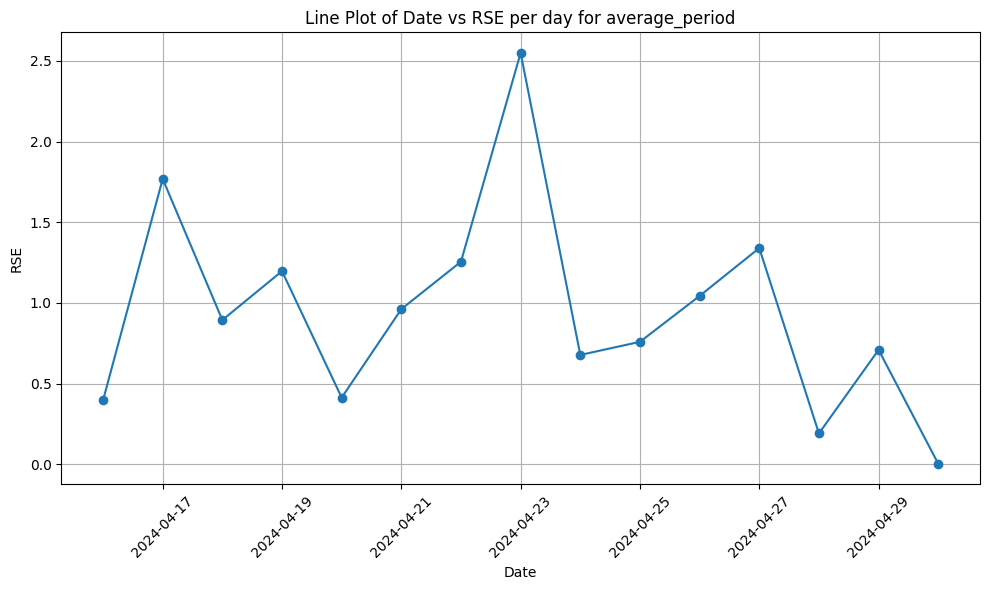

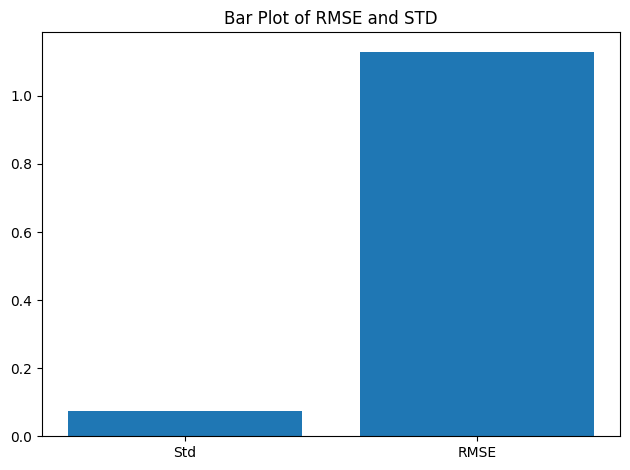

In [39]:
visualize("average_period", "46253")